In [7]:
# Setup for Google Colab (optional)
import sys
if 'google.colab' in sys.modules:
    print("Running in Google Colab")
    # Install required packages
    !pip install -q scikit-image matplotlib numpy scipy pillow
    
    # Set up file handling
    from google.colab import files
    print("Colab setup complete.")
else:
    print("Running in local environment")

Running in local environment


<a href="https://colab.research.google.com/github/NU-MSE-LECTURES/465-WINTER2026/blob/main/Week_03/code_examples/example_03_fft_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 03 Example 3: Frequency Domain Filtering with FFT

This notebook demonstrates filtering in the frequency domain using the Fast Fourier Transform (FFT).
We'll apply low-pass, high-pass, and band-pass filters to STEM-HAADF images.

## Overview: Frequency Domain vs Spatial Domain

### Spatial Domain (What We've Done):
- Apply filters directly to pixel values
- Convolution with kernel (e.g., Gaussian)
- Simple to visualize but computationally expensive for large kernels

### Frequency Domain (This Example):
- Transform image to frequency components
- Manipulate frequency content directly
- Transform back to spatial domain
- More efficient for large filters; reveals underlying structure

### Key Insight:
**Multiplication in frequency domain = Convolution in spatial domain**

Filter Types:
- **Low-Pass**: Removes high frequencies (noise, sharp features) → smooth image
- **High-Pass**: Removes low frequencies (background, contrast) → edge detection
- **Band-Pass**: Keep specific frequency range → structural filtering

## 1. Load Image and Compute FFT

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import os

# Load STEM-HAADF image
data_path = "../assignments/raw_data/STEM-HAADF-Aufcc-Auhcp.tif"

if os.path.exists(data_path):
    image = io.imread(data_path)
    print(f"✓ Image loaded successfully")
    print(f"  Shape: {image.shape}")
    print(f"  Value range: [{image.min()}, {image.max()}]")
else:
    print(f"✗ File not found at {data_path}")

# Compute FFT
image_float = image.astype(float)
fft_image = np.fft.fft2(image_float)
fft_shifted = np.fft.fftshift(fft_image)  # Shift zero-frequency to center

# Compute magnitude and phase
magnitude = np.abs(fft_shifted)
phase = np.angle(fft_shifted)
magnitude_log = np.log1p(magnitude)  # Log scale for better visualization

print(f"\n✓ FFT computed")
print(f"  FFT shape: {fft_shifted.shape}")
print(f"  Magnitude range: [{magnitude.min():.2e}, {magnitude.max():.2e}]")

✓ Image loaded successfully
  Shape: (960, 2048)
  Value range: [11532, 29761]

✓ FFT computed
  FFT shape: (960, 2048)
  Magnitude range: [2.80e+00, 3.63e+10]


## 2. Visualize Frequency Spectrum

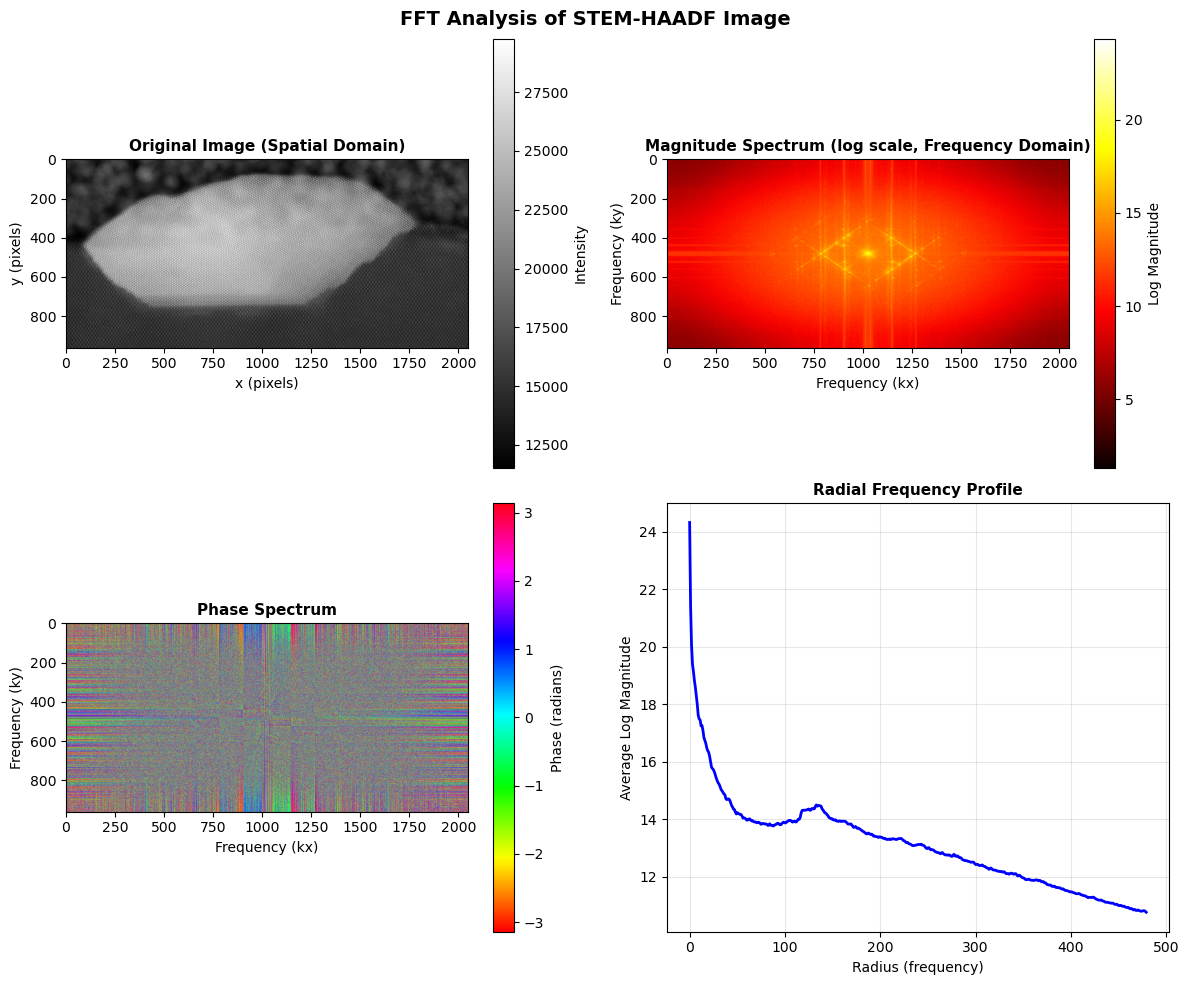


Frequency Domain Interpretation:
- Center (0,0): DC component (average intensity)
- Low frequencies (center): Broad features, contrast
- High frequencies (edges): Fine details, noise, sharp edges


In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('FFT Analysis of STEM-HAADF Image', fontsize=14, fontweight='bold')

# Original image
im0 = axes[0, 0].imshow(image, cmap='gray')
axes[0, 0].set_title('Original Image (Spatial Domain)', fontsize=11, fontweight='bold')
axes[0, 0].set_xlabel('x (pixels)')
axes[0, 0].set_ylabel('y (pixels)')
plt.colorbar(im0, ax=axes[0, 0], label='Intensity')

# Magnitude spectrum (log scale)
im1 = axes[0, 1].imshow(magnitude_log, cmap='hot')
axes[0, 1].set_title('Magnitude Spectrum (log scale, Frequency Domain)', fontsize=11, fontweight='bold')
axes[0, 1].set_xlabel('Frequency (kx)')
axes[0, 1].set_ylabel('Frequency (ky)')
plt.colorbar(im1, ax=axes[0, 1], label='Log Magnitude')

# Phase spectrum
im2 = axes[1, 0].imshow(phase, cmap='hsv')
axes[1, 0].set_title('Phase Spectrum', fontsize=11, fontweight='bold')
axes[1, 0].set_xlabel('Frequency (kx)')
axes[1, 0].set_ylabel('Frequency (ky)')
plt.colorbar(im2, ax=axes[1, 0], label='Phase (radians)')

# Radial frequency profile
center_y, center_x = fft_shifted.shape[0] // 2, fft_shifted.shape[1] // 2
max_radius = min(center_y, center_x)

radial_profile = []
for r in range(max_radius):
    y, x = np.ogrid[0:fft_shifted.shape[0], 0:fft_shifted.shape[1]]
    circle_mask = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    radial_profile.append(np.mean(magnitude_log[np.abs(circle_mask - r) < 1]))

axes[1, 1].plot(radial_profile, 'b-', linewidth=2)
axes[1, 1].set_title('Radial Frequency Profile', fontsize=11, fontweight='bold')
axes[1, 1].set_xlabel('Radius (frequency)')
axes[1, 1].set_ylabel('Average Log Magnitude')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nFrequency Domain Interpretation:")
print("- Center (0,0): DC component (average intensity)")
print("- Low frequencies (center): Broad features, contrast")
print("- High frequencies (edges): Fine details, noise, sharp edges")

## 3. Low-Pass Filtering (Smooth/Denoise)

Low-pass filter (radius=10) applied
Low-pass filter (radius=30) applied
Low-pass filter (radius=60) applied


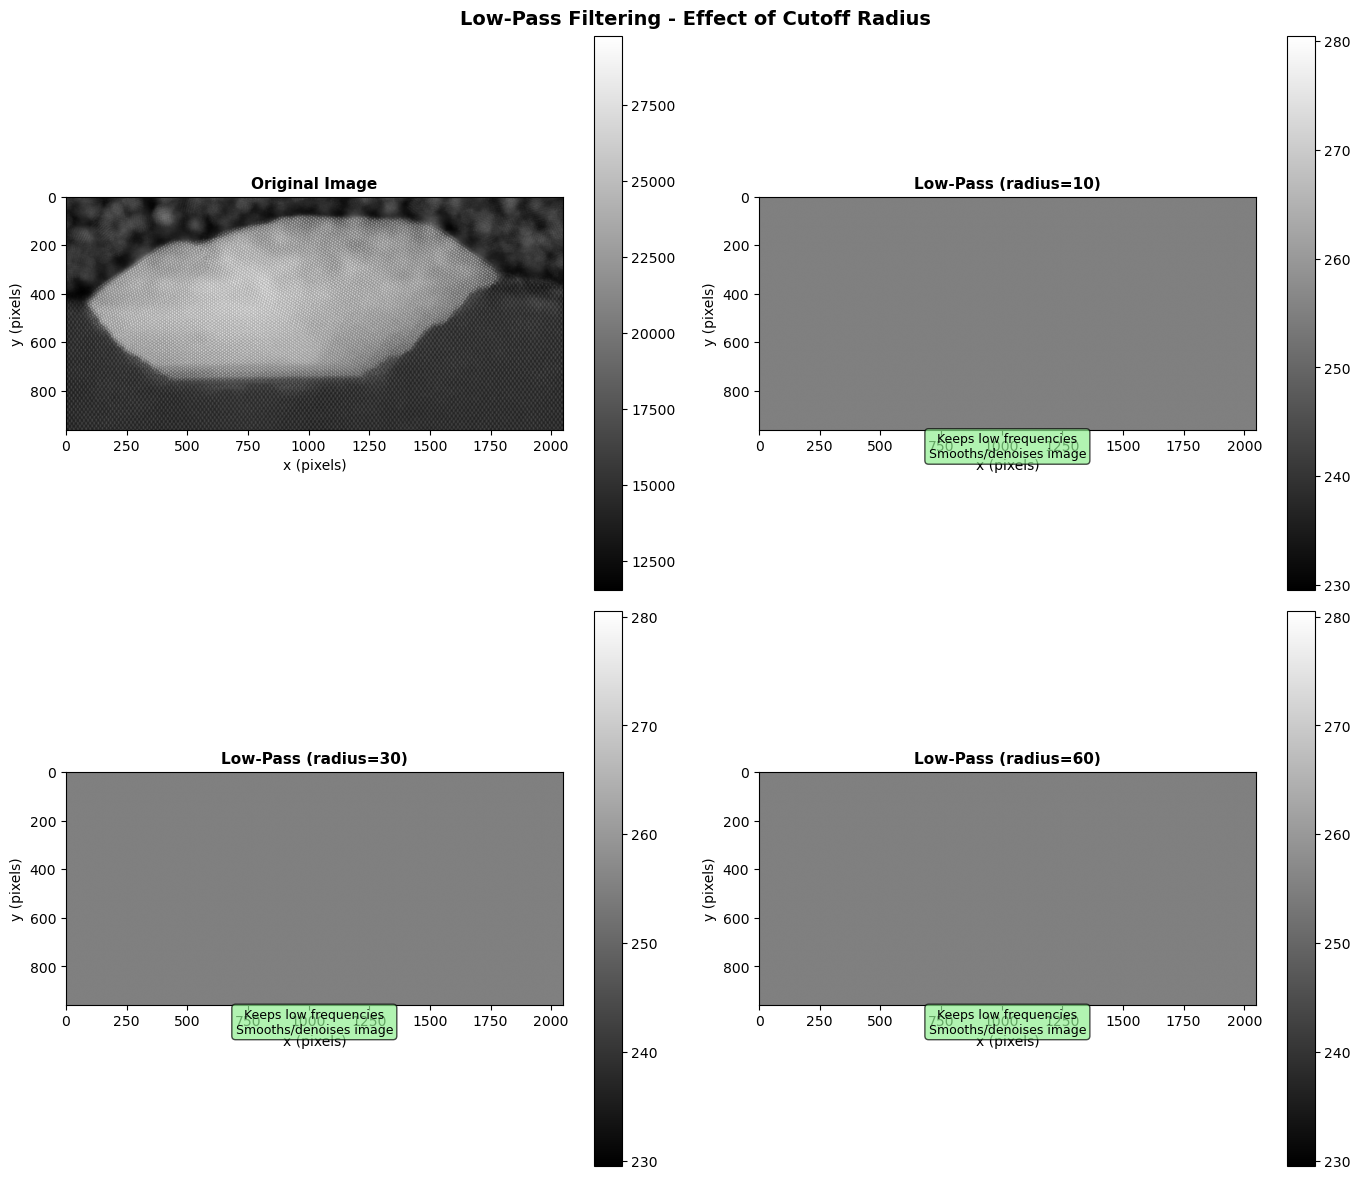


Low-Pass Filter Characteristics:
✓ Removes high-frequency noise
✓ Smooths sharp transitions
✗ Loses fine structural details
✗ Blurs edges (similar to Gaussian in spatial domain)


In [11]:
def create_lowpass_mask(shape, radius):
    """Create a circular low-pass filter mask."""
    center_y, center_x = shape[0] // 2, shape[1] // 2
    y, x = np.ogrid[0:shape[0], 0:shape[1]]
    distance = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    mask = distance <= radius
    return mask.astype(float)

# Apply low-pass filters with different cutoff radii
cutoff_radii = [10, 30, 60]
lowpass_results = {}

for radius in cutoff_radii:
    mask = create_lowpass_mask(fft_shifted.shape, radius)
    fft_filtered = fft_shifted * mask
    image_filtered = np.fft.ifft2(np.fft.ifftshift(fft_filtered)).real
    lowpass_results[radius] = image_filtered
    print(f"Low-pass filter (radius={radius}) applied")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Low-Pass Filtering - Effect of Cutoff Radius', fontsize=14, fontweight='bold')

# Original
im0 = axes[0, 0].imshow(image, cmap='gray')
axes[0, 0].set_title('Original Image', fontsize=11, fontweight='bold')
plt.colorbar(im0, ax=axes[0, 0])

# Low-pass results
for idx, radius in enumerate(cutoff_radii):
    row = (idx + 1) // 2
    col = (idx + 1) % 2
    im = axes[row, col].imshow(np.clip(lowpass_results[radius], 0, 255), cmap='gray')
    axes[row, col].set_title(f'Low-Pass (radius={radius})', fontsize=11, fontweight='bold')
    axes[row, col].text(0.5, -0.12, f'Keeps low frequencies\nSmooths/denoises image', 
                        transform=axes[row, col].transAxes, ha='center', fontsize=9,
                        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
    plt.colorbar(im, ax=axes[row, col])

for ax in axes.flat:
    ax.set_xlabel('x (pixels)')
    ax.set_ylabel('y (pixels)')

plt.tight_layout()
plt.show()

print("\nLow-Pass Filter Characteristics:")
print("✓ Removes high-frequency noise")
print("✓ Smooths sharp transitions")
print("✗ Loses fine structural details")
print("✗ Blurs edges (similar to Gaussian in spatial domain)")

## 4. High-Pass Filtering (Edge Detection)

High-pass filter (radius=10) applied
High-pass filter (radius=30) applied
High-pass filter (radius=60) applied


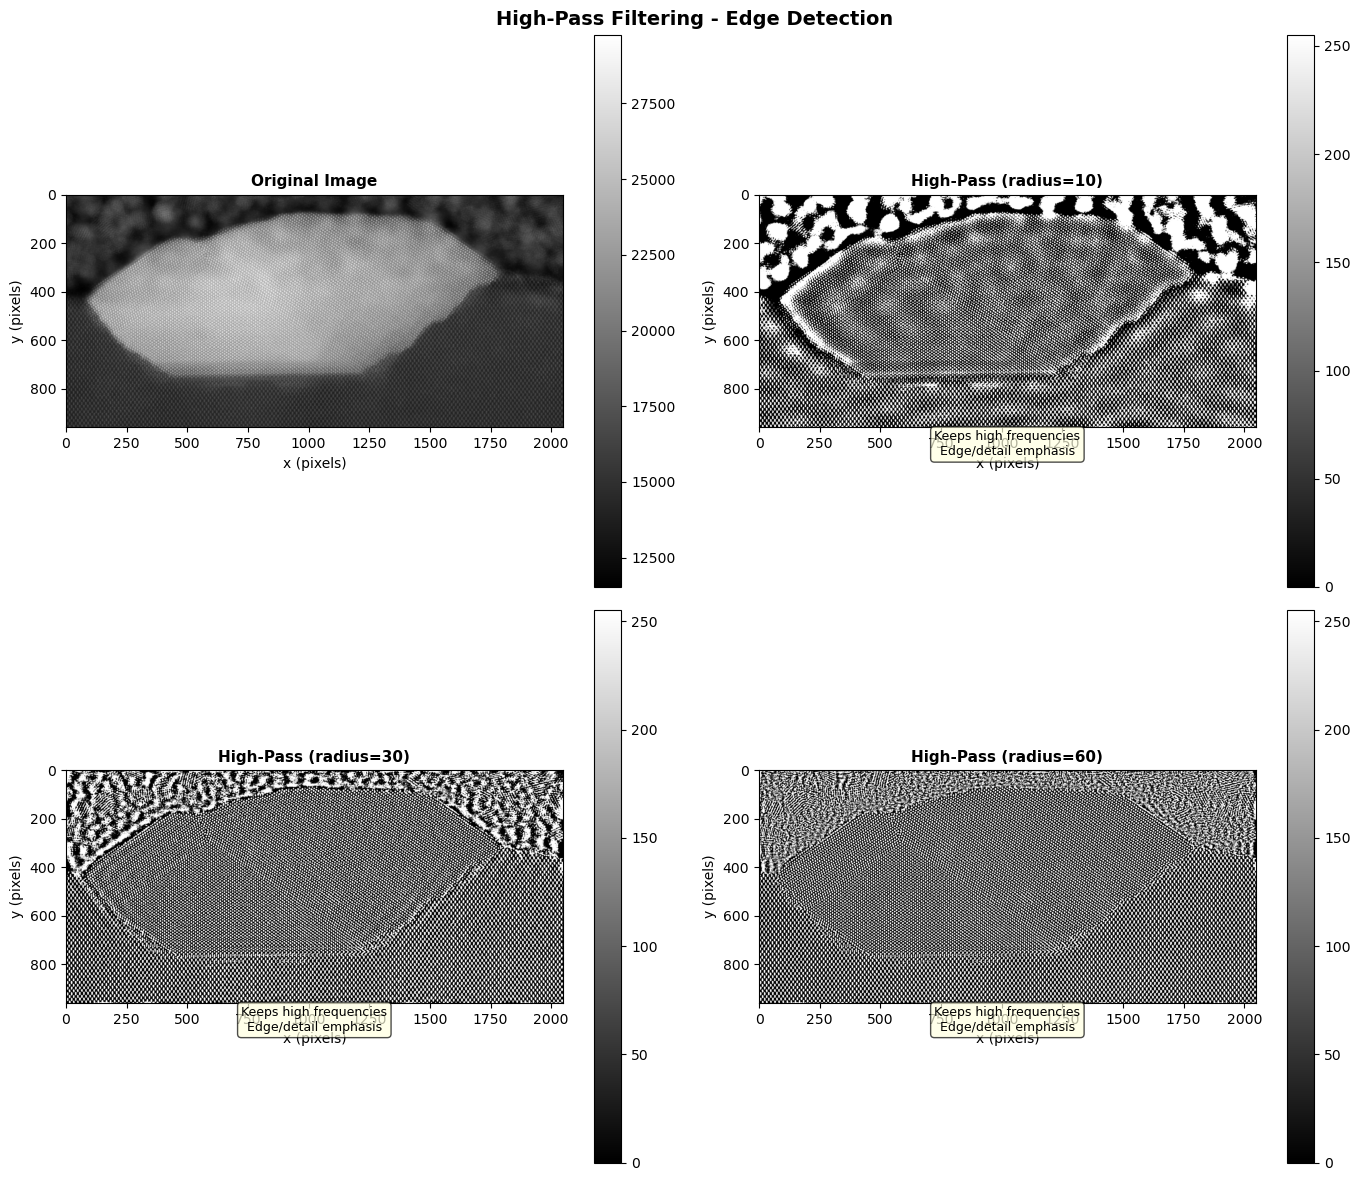


High-Pass Filter Characteristics:
✓ Reveals edges and fine details
✓ Removes background/contrast information
✗ Amplifies noise
✗ Hard to interpret (mainly shows transitions)


In [12]:
def create_highpass_mask(shape, radius):
    """Create a circular high-pass filter mask."""
    lowpass = create_lowpass_mask(shape, radius)
    return 1 - lowpass  # Inverse

# Apply high-pass filters with different cutoff radii
cutoff_radii_hp = [10, 30, 60]
highpass_results = {}

for radius in cutoff_radii_hp:
    mask = create_highpass_mask(fft_shifted.shape, radius)
    fft_filtered = fft_shifted * mask
    image_filtered = np.fft.ifft2(np.fft.ifftshift(fft_filtered)).real
    highpass_results[radius] = image_filtered
    print(f"High-pass filter (radius={radius}) applied")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('High-Pass Filtering - Edge Detection', fontsize=14, fontweight='bold')

# Original
im0 = axes[0, 0].imshow(image, cmap='gray')
axes[0, 0].set_title('Original Image', fontsize=11, fontweight='bold')
plt.colorbar(im0, ax=axes[0, 0])

# High-pass results
for idx, radius in enumerate(cutoff_radii_hp):
    row = (idx + 1) // 2
    col = (idx + 1) % 2
    # Center around 128 for better visualization
    filtered = highpass_results[radius]
    filtered_centered = filtered - filtered.mean() + 128
    im = axes[row, col].imshow(np.clip(filtered_centered, 0, 255), cmap='gray')
    axes[row, col].set_title(f'High-Pass (radius={radius})', fontsize=11, fontweight='bold')
    axes[row, col].text(0.5, -0.12, f'Keeps high frequencies\nEdge/detail emphasis', 
                        transform=axes[row, col].transAxes, ha='center', fontsize=9,
                        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))
    plt.colorbar(im, ax=axes[row, col])

for ax in axes.flat:
    ax.set_xlabel('x (pixels)')
    ax.set_ylabel('y (pixels)')

plt.tight_layout()
plt.show()

print("\nHigh-Pass Filter Characteristics:")
print("✓ Reveals edges and fine details")
print("✓ Removes background/contrast information")
print("✗ Amplifies noise")
print("✗ Hard to interpret (mainly shows transitions)")

## 5. Band-Pass Filtering (Structural Analysis)

Band-pass filter (radius 5-20) applied
Band-pass filter (radius 20-50) applied
Band-pass filter (radius 50-100) applied


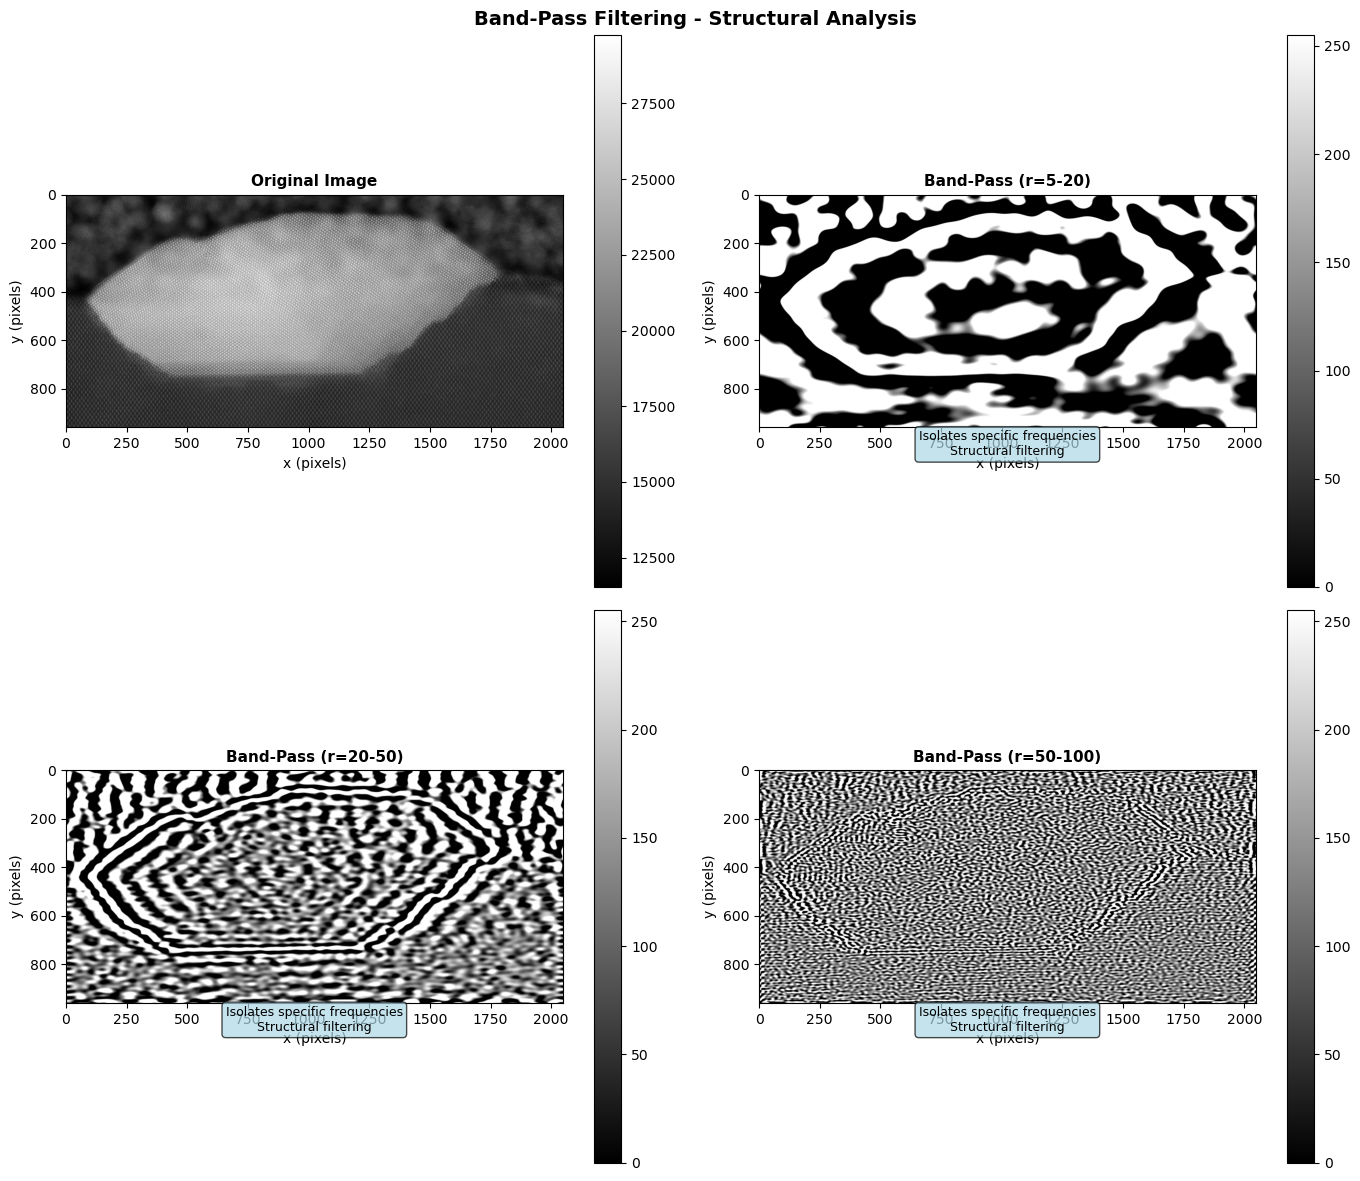


Band-Pass Filter Characteristics:
✓ Isolates specific size features
✓ Useful for structural analysis
✓ Can enhance features in specific frequency range
✗ Removes both very low and very high frequencies


In [6]:
def create_bandpass_mask(shape, inner_radius, outer_radius):
    """Create an annular band-pass filter mask."""
    center_y, center_x = shape[0] // 2, shape[1] // 2
    y, x = np.ogrid[0:shape[0], 0:shape[1]]
    distance = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    mask = (distance >= inner_radius) & (distance <= outer_radius)
    return mask.astype(float)

# Apply band-pass filters
band_configs = [(5, 20), (20, 50), (50, 100)]
bandpass_results = {}

for inner, outer in band_configs:
    mask = create_bandpass_mask(fft_shifted.shape, inner, outer)
    fft_filtered = fft_shifted * mask
    image_filtered = np.fft.ifft2(np.fft.ifftshift(fft_filtered)).real
    bandpass_results[(inner, outer)] = image_filtered
    print(f"Band-pass filter (radius {inner}-{outer}) applied")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Band-Pass Filtering - Structural Analysis', fontsize=14, fontweight='bold')

# Original
im0 = axes[0, 0].imshow(image, cmap='gray')
axes[0, 0].set_title('Original Image', fontsize=11, fontweight='bold')
plt.colorbar(im0, ax=axes[0, 0])

# Band-pass results
for idx, (inner, outer) in enumerate(band_configs):
    row = (idx + 1) // 2
    col = (idx + 1) % 2
    filtered = bandpass_results[(inner, outer)]
    filtered_centered = filtered - filtered.mean() + 128
    im = axes[row, col].imshow(np.clip(filtered_centered, 0, 255), cmap='gray')
    axes[row, col].set_title(f'Band-Pass (r={inner}-{outer})', fontsize=11, fontweight='bold')
    axes[row, col].text(0.5, -0.12, f'Isolates specific frequencies\nStructural filtering', 
                        transform=axes[row, col].transAxes, ha='center', fontsize=9,
                        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    plt.colorbar(im, ax=axes[row, col])

for ax in axes.flat:
    ax.set_xlabel('x (pixels)')
    ax.set_ylabel('y (pixels)')

plt.tight_layout()
plt.show()

print("\nBand-Pass Filter Characteristics:")
print("✓ Isolates specific size features")
print("✓ Useful for structural analysis")
print("✓ Can enhance features in specific frequency range")
print("✗ Removes both very low and very high frequencies")

## 6. Summary: Frequency Domain Filtering

### Filter Type Comparison:

| Filter | Frequency Content | Effect | Use Case |
|--------|------------------|--------|----------|
| **Low-Pass** | Keep low freq only | Smooth/denoise | Remove noise, reduce detail |
| **High-Pass** | Remove low freq | Edge detection | Find boundaries, structural analysis |
| **Band-Pass** | Keep freq range | Isolate features | Size-selective filtering |

### Advantages of Frequency Domain:
- Intuitive understanding of frequency content
- Efficient implementation for large filters
- Can visualize what frequencies are being affected
- Useful for periodic noise removal

### For STEM Data:
- **Low-pass**: Remove detector noise while preserving atomic structure
- **Band-pass**: Isolate atomic-scale features (specific d-spacings)
- **High-pass**: Enhance edges between different crystal phases
- **Notch filters**: Remove periodic noise (CCD artifacts)